# <center>tensorflow2.0加载图像数据及模型finetune</center>

By [青衣极客 Blue Geek](https://mp.weixin.qq.com/s/vNziVCJ7WBh7P6-OQrsTyg)

In 2019-10-30

从事图像处理或者计算机视觉的朋友可能会有使用tensorflow加载图像数据的需求，这些数据可以是公开数据集，也可以是自己制作的私有数据集。tensorflow提供了一些接口来导入图像数据，并使用Dataset方便地管理这些数据。如果是常用的公开数据集，可能已经有了比较好的数据载入相关的代码封装，这时就没有必要重复造轮子了。而对于一些不常用的公开数据集，往往需要自己编写代码载入数据，至于自己制作的或者数据组织形式罕见的那就更加需要自己动手了。本文就讨论一种载入图像数据的方法，对tensorflow在数据载入方面不太熟悉的朋友可能会有些收获。

## 1. 加载图片数据

我们首选需要将这些图片数据加载到内存中，当然并不是一定要一次性加载进内存，更常见的情况是使用生产者和消费者模型一边训练，一边加载。一般而言，分为两步，(1)加载图像文件的路径，(2)提供接口根据路径加载图像数据。下面就分步骤说明数据加载方面的操作详情。

### (1) 获取图像文件路径

首先使用pathlib模块中提供的一些处理路径相关的操作提取指定根目录下所有图像文件的路径。在python中完成这种操作的方式很多，这里只是其中一种。

In [35]:
import pathlib
import random
# 指定数据图片文件所在根目录
data_path = pathlib.Path('../../data/flower_photos')
print('图像数据根目录:', data_path)
for i in data_path.iterdir():
    print('根目录下的子目录及文件：', i)
# 获取所有图片文件的路径，并随机排列
img_paths = list(data_path.glob('*/*'))
img_paths = [str(p) for p in img_paths]
random.shuffle(img_paths)
print('图片文件路径展示：', img_paths[:10])

图像数据根目录: ../../data/flower_photos
根目录下的子目录及文件： ../../data/flower_photos/roses
根目录下的子目录及文件： ../../data/flower_photos/.DS_Store
根目录下的子目录及文件： ../../data/flower_photos/sunflowers
根目录下的子目录及文件： ../../data/flower_photos/daisy
根目录下的子目录及文件： ../../data/flower_photos/dandelion
根目录下的子目录及文件： ../../data/flower_photos/tulips
根目录下的子目录及文件： ../../data/flower_photos/LICENSE.txt
图片文件路径展示： ['../../data/flower_photos/roses/2627513944_b1361e60ec_m.jpg', '../../data/flower_photos/tulips/15029962436_3e50c1f30f_n.jpg', '../../data/flower_photos/tulips/470690620_9d3a5bb239.jpg', '../../data/flower_photos/dandelion/4574451859_432c856b6e_n.jpg', '../../data/flower_photos/daisy/18582579815_4c6637e9ff_m.jpg', '../../data/flower_photos/daisy/4534460263_8e9611db3c_n.jpg', '../../data/flower_photos/dandelion/3149809654_6a4b31314d_n.jpg', '../../data/flower_photos/daisy/154332674_453cea64f4.jpg', '../../data/flower_photos/dandelion/16987075_9a690a2183.jpg', '../../data/flower_photos/daisy/5014137563_d03eb0ed75_n.jpg']


### (2) 查看图像及对应属性

获取图像路径之后，我们需要查看一下原始数据的具体形式，以对需要处理的数据有一个基本的认识。这一步对后续程序运行而言没有影响，但是在日常的工作和科研中间不可或缺。

<IPython.core.display.Javascript object>


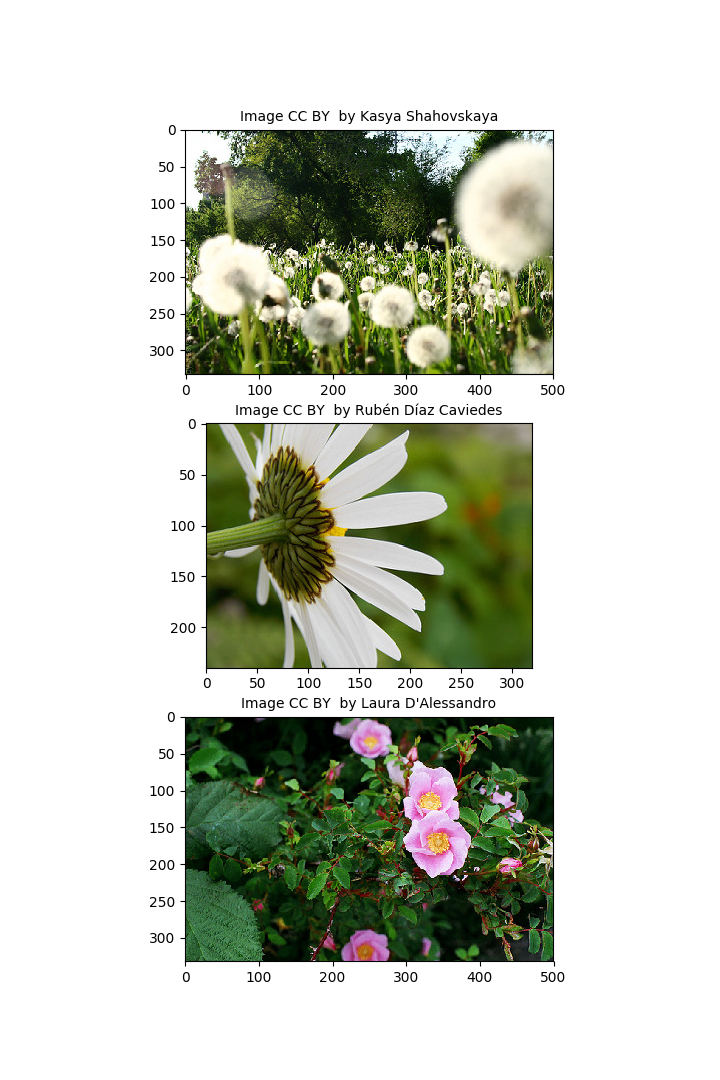

In [12]:
%matplotlib notebook
import matplotlib.pyplot as plt

# 读取图片的属性信息
record_text = (data_path/'LICENSE.txt').open().readlines()[4:]
attrs = [line.split(' CC-BY') for line in record_text]
attrs = dict(attrs)  # 生成一个路径到属性说明的映射词典

def get_attr(img_path):
    """
    功能： 获取指定图片的属性信息
    """
    img_rel = pathlib.Path(img_path).relative_to(data_path)
    return 'Image CC BY ' + '-'.join(attrs[str(img_rel)].split(' - ')[:-1])

# 可视化若干张图片
plt.figure(figsize=(7.2, 10.8))
for i in range(3):
    img_path = img_paths[i]
    img_attr = get_attr(img_path)
    img = plt.imread(img_path)
    plt.subplot(3, 1, i+1)
    plt.imshow(img)
    plt.title(img_attr, fontdict={'fontSize':10})
plt.show()

### (3) 获取图像标签

原始的图像数据检查完毕，没有问题。接下来就需要处理图像标记相关的数据。这里演示的是一个分类问题的数据集，对于回归问题处理步骤也是一样的，只是在这一步载入的信息稍有差别。

In [36]:
# 获取标签名
label_names = sorted(i.name for i in data_path.glob('*/') if i.is_dir())
print(label_names)
# 创建标签名到索引的映射词典
name_index_dict = dict((name, idx) for idx,name in enumerate(label_names))
print(name_index_dict)
# 获取所有图像文件对应的标签
img_labels = [name_index_dict[pathlib.Path(p).parent.name] for p in img_paths]
print(img_labels[:10])

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}
[2, 4, 4, 1, 0, 0, 1, 0, 1, 0]


### (4) 添加载入接口并测试

在实际使用这些图像数据时，并不是一次载入的，而是需要在使用过程中载入。这是就需要定义一个图像的载入和预处理函数作为钩子函数被数据管理器调用。不明白钩子函数作用的朋友可以先不用管。这里只需明白，编写一个数据载入和预处理的操作即可。下面的演示验证了这个接口的有效性，以及图像数据与标签数据之间的匹配是否正确。

/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/local/Cellar/python/3.7.4/Frameworks/Python.framework/Versions/3.7/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C head

<IPython.core.display.Javascript object>


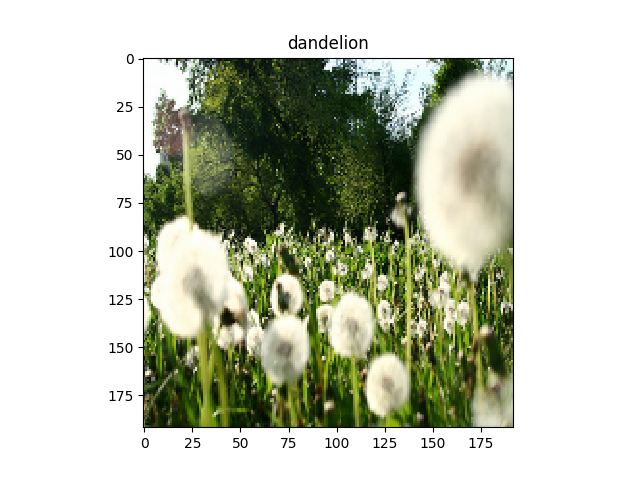

In [17]:
import tensorflow as tf
def load_preprocess_img(img_path):
    """
    功能：用于根据指定路径载入图片文件
    """
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (192,192))
    img /= 255.0
    return img
# 可视化load_preprocess_img函数载入图片
plt.figure()
plt.imshow(load_preprocess_img(img_paths[0]))
plt.title(label_names[img_labels[0]])
plt.show()

## 2. 创建Dataset

图像数据的路径和标签都准备好了之后，就需要创建数据管理器Dataset。很多的机器学习框架都提供了各自的数据管理器，原理大同小异，对于大量图像数据基本都是使用异步的方式按需要载入数据。下面就讨论一下tensorflow中管理器的用法。

### (1) 构造图像-标签配对数据集

将图像文件路径和对应的载入操作绑定到Dataset之后，这个管理器就具备了提供图像数据的功能。将这样的图像数据管理器和对应的标签数据管理器匹配之后就可以得到一个完整的分类问题的数据集。

In [19]:
# 创建标签Dataset
labels_ds = tf.data.Dataset.from_tensor_slices(tf.cast(img_labels, tf.int64))
# 创建图像Dataset
img_path_ds = tf.data.Dataset.from_tensor_slices(img_paths)
imgs_ds = img_path_ds.map(load_preprocess_img,  # 指定载入和预处理函数
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
# 将标签与图像包装成整体Dataset
img_label_ds = tf.data.Dataset.zip((imgs_ds, labels_ds))
print(img_label_ds)

<ZipDataset shapes: ((192, 192, 3), ()), types: (tf.float32, tf.int64)>


### (2) 设置数据集参数和操作

熟悉深度学习的朋友都知道，我们在使用训练数据集时常常需要对数据进行随机排列，这也算是一种数据增强的手段了，避免模型将数据点的排列方式当作一种特征而造成过拟合。此外，一个数据集往往需要训练很多遍，这是就需要进行一些repeat操作。不过shuffle与repeat以及batch操作的顺序会对随机排列的效果有影响。将随机排列放在最前面，就是保证我们通常所期望的epoch内部打散。最后还需要设置一个prefetch操作，这样有利于异步读取数据的时候充分发挥计算机的能力。

In [21]:
# 随机排列
dataset = img_label_ds.shuffle(buffer_size=len(img_paths))
# 重复
dataset = dataset.repeat()
# 设置batch size
dataset = dataset.batch(32)
# 设置预先载入操作
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
print(dataset)

<PrefetchDataset shapes: ((None, 192, 192, 3), (None,)), types: (tf.float32, tf.int64)>


## 3. 训练模型

数据准备完成之后就可以训练数据了，这里演示的是以一个MobileNetV2的模型为基础进行finetune。finetune的意思是在一个已经训练好的模型的基础上，添加新的结构和参数而保持基础模型的参数不改变，训练时只需训练新加参数。在图像领域，比较常用的基础模型还有VGG16、VGG19、ResNet等等。

### (1) 获取基准模型

keras提供了获取MobileNetV2模型参数和结构的方法，直接使用接口下载对应的模型文件即可。

In [24]:
from tensorflow.keras.applications import MobileNetV2
# 使用已有模型作为基准
mobile_net = MobileNetV2(input_shape=(192, 192, 3), include_top=False)
mobile_net.trainable = False

9412608/9406464 [==============================] - 51s 5us/step


### (2) 适配输入数据数值范围

由于基础模型的输入要求数据的数值范围在[-1,1]，而之前预处理函数中的归一化操作得到的数值范围是[0,1]，所以需要进行一次变换。还可以使用一个batch的图像数据测试一下MobileNetV2的输出量的形状。

In [26]:
def change_range(img, lbl):
    return 2*img-1, lbl
# 改变图像数据的数值范围到[-1,1]
keras_dataset = dataset.map(change_range)
# 查看mobileneV2的输出
for imgs, lbls in keras_dataset:
    break
feats = mobile_net(imgs)
print(feats.shape)

(32, 6, 6, 1280)


### (3) 构建模型并查看设置

基础模型准备完成之后就可以添加新的结构和参数，构建完整的模型了。这里的演示只是添加了两个简单的操作，增加了两个需要在训练中调整的张量参数。还可以将创建的模型的结构打印出来查看一下，符合预期。

In [32]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy

# 创建模型
model = Sequential([
    mobile_net,
    GlobalAveragePooling2D(),
    Dense(len(label_names), activation='softmax')
])
# 设置优化器和损失函数
model.compile(optimizers=Adam(), 
              loss=sparse_categorical_crossentropy, 
              metrics=['accuracy'])
print(model(imgs).shape)           # 打印输出量的形状
print(model.trainable_variables)   # 查看需要训练的参数
model.summary()                    # 查看模型配置

(32, 5)
[<tf.Variable 'dense_5/kernel:0' shape=(1280, 5) dtype=float32, numpy=
array([[-0.05291509, -0.0636892 ,  0.06593068,  0.06087527,  0.01046919],
       [-0.04747346, -0.05240949,  0.00184242,  0.06481114,  0.05076039],
       [ 0.02187667, -0.01766189,  0.03114005,  0.00230976, -0.02524894],
       ...,
       [-0.015651  , -0.03465771, -0.03879043, -0.05046549, -0.02792818],
       [-0.02144933, -0.03491878,  0.02299811, -0.02606232,  0.04206034],
       [ 0.02402507, -0.05170669, -0.02909772, -0.00767438,  0.05787331]],
      dtype=float32)>, <tf.Variable 'dense_5/bias:0' shape=(5,) dtype=float32, numpy=array([0., 0., 0., 0., 0.], dtype=float32)>]
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Model) (None, 6, 6, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_5 ( (None, 1280)       

### (4) 训练模型

一切准备就绪，就可以开始训练模型。由于在数据管理器中使用了repeat操作，所以需要指定每一个epoch训楼的步数。一般而言，一个epoch就是将数据集遍历一遍。这里设置将数据集遍历10遍。从训楼安的损失函数来看，将数据集遍历到第7遍之后就已经收敛了。

In [34]:
# 训练模型
steps_per_epoch = tf.math.ceil(len(img_paths)/32).numpy()
model.fit(keras_dataset, steps_per_epoch=steps_per_epoch, epochs=10)

Train for 115.0 steps
Epoch 1/10
115/115 [==============================] - 83s 718ms/step - loss: 0.8019 - accuracy: 0.6970
Epoch 2/10
115/115 [==============================] - 79s 686ms/step - loss: 0.4396 - accuracy: 0.8457
Epoch 3/10
115/115 [==============================] - 80s 696ms/step - loss: 0.3603 - accuracy: 0.8755
Epoch 4/10
115/115 [==============================] - 80s 697ms/step - loss: 0.3205 - accuracy: 0.8861
Epoch 5/10
115/115 [==============================] - 83s 725ms/step - loss: 0.3033 - accuracy: 0.8913
Epoch 6/10
115/115 [==============================] - 81s 703ms/step - loss: 0.2660 - accuracy: 0.9035
Epoch 7/10
115/115 [==============================] - 80s 692ms/step - loss: 0.2548 - accuracy: 0.9144
Epoch 8/10
115/115 [==============================] - 80s 695ms/step - loss: 0.2457 - accuracy: 0.9125
Epoch 9/10
115/115 [==============================] - 79s 686ms/step - loss: 0.2320 - accuracy: 0.9236
Epoch 10/10
115/115 [==============================

到此，在tensorflow2.0中载入图像数据和模型finetune操作就讨论完毕。本文是在学习官网教程之后编写的，基本流程与官网一致。喜欢阅读官网教程的朋友可以查看[链接](https://www.tensorflow.org/tutorials/load_data/images) 。